In [1]:
import os
import cooler
import cooltools.snipping
import bioframe
import pandas as pd
from NGS import HiCTools as HT
from collections import defaultdict
import re
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import ttest_ind
import matplotlib.colors as cl
import matplotlib
import warnings
from typing import Tuple

In [2]:
# ignore warnings (log10(0))
warnings.simplefilter("ignore", RuntimeWarning)

# Define plotting parameters

In [3]:
matplotlib.rcParams.update({"font.size": 12})
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [4]:
def recDict():
    return defaultdict(recDict)

def getPairingScoreObsExp(clr: cooler.Cooler, expected: pd.DataFrame ,windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupObsExp(clr, expected, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    # replace inf with nan
    pileFrame = pileFrame.replace([np.inf, -np.inf], np.nan)
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def setAxis(ax, ticks_pixels, ticks_kbp):
    if not isinstance(ax, np.ndarray):
        ax.set_xticks(ticks_pixels)
        ax.set_xticklabels(ticks_kbp)
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_xlabel('relative position, kbp')
        ax.set_ylabel('relative position, kbp')
        return
    if len(ax.shape) == 1:
        for i in range(len(ax)):
            ax[i].set_xticks(ticks_pixels)
            ax[i].set_xticklabels(ticks_kbp)
            ax[i].set_yticks(ticks_pixels)
            ax[i].set_yticklabels(ticks_kbp)
            ax[i].set_xlabel('relative position, kbp')
            ax[i].set_ylabel('relative position, kbp')
        return
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].set_xticks(ticks_pixels)
            ax[i, j].set_xticklabels(ticks_kbp)
            ax[i, j].set_yticks(ticks_pixels)
            ax[i, j].set_yticklabels(ticks_kbp)
            ax[i, j].set_xlabel('relative position, kbp')
            ax[i, j].set_ylabel('relative position, kbp')

# from https://stackoverflow.com/questions/10925671/numpy-k-th-diagonal-indices
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols


def slidingDiamond(array: np.ndarray, sideLen: int = 6, centerX: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Will slide a dimaond of side length 'sideLen'
    down the diagonal of the passed array and return
    the average values for each position and
    the relative position of each value with respect
    to the center of the array (in Bin units)"""
    # initialize accumulators for diamond value and x-position
    diamondAccumulator = list()
    binAccumulator = list()
    if sideLen % 2 == 0:
        halfWindow = sideLen
        for i in range(0, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i: (i+halfWindow) + 1, i:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i, (i+halfWindow) + 1,)))
    else:
        halfWindow = sideLen//2
        for i in range(halfWindow, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i-halfWindow: (i+halfWindow) + 1, i-halfWindow:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i - halfWindow, (i+halfWindow) + 1,)))
    if centerX:
        xOut = (np.array(binAccumulator - np.median(binAccumulator)))
    else:
        xOut = np.array(binAccumulator)
    return (xOut, np.array(diamondAccumulator))

# Set wd

In [5]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/")

# Plot histogram of obs/exp score at boundaries

## Get chromosomal arms and define cooler handles

In [14]:
chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

In [17]:
HICPATH = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

BINSIZE = 10000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Calculate expected

In [26]:
exp = {interType:
       HT.getExpected(clrs[interType], arms)
       for interType in ["cis", "trans"]
       }

## Load TAD
TADs called on binsize of 50kb with maxsize of 6Mbp

In [8]:
tadFrame = pd.read_csv("tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)[[0, 1, 2]]
tadFrame.columns = ["chrom", "start", "end"]

## Calculate boundaries

In [22]:
# boundaries are gonna be stard and end together
tadStart = tadFrame[["chrom", "start"]]
tadStart.columns = ["chrom", "mid"]
tadEnd = tadFrame[["chrom", "end"]]
tadEnd.columns = ["chrom", "mid"]
# here duplicates are removed
tadFinal = pd.concat((tadStart, tadEnd)).drop_duplicates()

## Get pairing score at these regions for cis and trans
Pairing score is calculated with a halfwindowsize of 40kb (=80kb windowsize)

In [12]:
transPairObsExp = getPairingScoreObsExp(clrs["trans"], exp["trans"], regions=tadFinal, norm=False, windowsize=4 * 10**4)

In [13]:
transPairObsExp.loc[:, "log2Pair"] = np.log2(transPairObsExp["PairingScore"])
transPairObsExp = transPairObsExp.replace([np.inf, -np.inf], np.nan).dropna()

In [14]:
cisPairObsExp = getPairingScoreObsExp(clrs["cis"], exp["cis"], regions=tadFinal, norm=False, windowsize=4 * 10**4)

In [15]:
cisPairObsExp.loc[:, "log2Pair"] = np.log2(cisPairObsExp["PairingScore"])
cisPairObsExp = cisPairObsExp.replace([np.inf, -np.inf], np.nan).dropna()

## Plot results (logarithmic values)

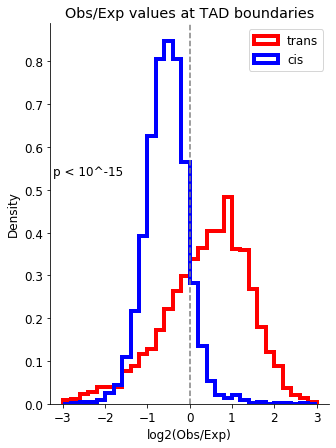

In [16]:
# perform ttest

s, p = ttest_ind(transPairObsExp["log2Pair"], cisPairObsExp["log2Pair"])

try:
    orderOfMag = int(np.log10(p))
except OverflowError:
    # in case p-value is closer to 0 than the precision limit of np.float64
    orderOfMag = -15

f, ax = plt.subplots()
ax.hist(transPairObsExp["log2Pair"], density=True, bins=30, range=(-3, 3), histtype="step", color="red", lw=4, label="trans")
ax.hist(cisPairObsExp["log2Pair"], density=True, bins=30, range=(-3, 3), histtype="step", color="blue", lw=4, label="cis")
ax.set(xlabel="log2(Obs/Exp)", ylabel="Density", title="Obs/Exp values at TAD boundaries")
ax.text(0.01, 0.6, f"p < 10^{orderOfMag}", transform=ax.transAxes)
ax.legend()
sbn.despine()
ax.axvline(x=0, ls="--", color="grey")
f.set_size_inches(5, 7)
plt.show()

## Write to file

In [80]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "Log2_obs_exp_pairing_boundaries.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Log2_obs_exp_pairing_boundaries.pdf"), bbox_inches="tight")

# 2d-pileup of TADs (ICCF)

In [9]:
tadFrame.loc[:, "size"] = tadFrame["end"] - tadFrame["start"]
tadFrame

,chrom,start,end,size
0,chr6,275000,3275000,3000000
1,chr6,275000,2725000,2450000
2,chr6,275000,1575000,1300000
3,chr6,275000,575000,300000
4,chr6,575000,1575000,1000000
...,...,...,...,...
5799,chr10,132025000,133275000,1250000
5800,chr10,133675000,135125000,1450000
5801,chr10,133675000,134475000,800000
5802,chr10,134475000,135125000,650000


In [11]:
tadSized = tadFrame.loc[(tadFrame["size"] > 300000) & (tadFrame["size"] < 500000), :]
tadSized.loc[:, "mid"] = (tadSized["start"] + tadSized["end"]) // 2
tadSized

,chrom,start,end,size,mid
8,chr6,3275000,3725000,450000,3500000
12,chr6,5075000,5425000,350000,5250000
16,chr6,7275000,7625000,350000,7450000
18,chr6,7625000,8075000,450000,7850000
21,chr6,8075000,8475000,400000,8275000
...,...,...,...,...,...
5771,chr10,118575000,118925000,350000,118750000
5781,chr10,123675000,124025000,350000,123850000
5786,chr10,125325000,125725000,400000,125525000
5787,chr10,125725000,126075000,350000,125900000


In [15]:
windows = HT.assignRegions(450000, 10000, tadSized["chrom"], tadSized["mid"], arms).dropna()

In [18]:
pileupICCF = {interType: HT.doPileupICCF(clrs[interType], windows)
          for interType in ["cis", "trans"]}

## Plot result

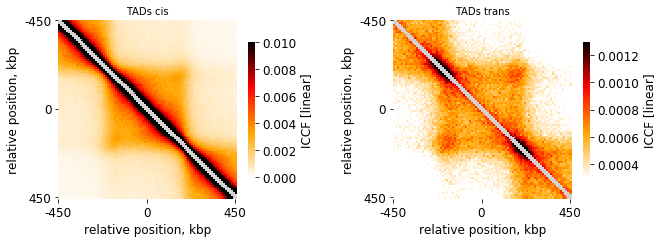

In [19]:
WINDOW_HALF_SIZE = 450000
BINSIZE = 10000

cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")

minMaxMap = {'cis': (0, 0.01), 'trans': (0.0003, 0.0013)}

f, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
for index, rtype in enumerate(["cis", "trans"]):
    temp = pileupICCF[rtype].copy()
    for i in range(-1, 2):
        temp[kth_diag_indices(temp, i)] = np.nan
    sbn.heatmap(temp, ax=ax[index],
                square=True, 
                rasterized=True,
                cmap=cmap,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={"shrink": .5, "label": "ICCF [linear]"},
                vmin=minMaxMap[rtype][0],
                vmax=minMaxMap[rtype][1])
    ax[index].set_title(f"TADs {rtype}",
                        fontdict={"fontsize": 10})
    ticks_pixels = np.linspace(0, WINDOW_HALF_SIZE*2//BINSIZE, 3)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*BINSIZE//1000).astype(int)
setAxis(ax, ticks_pixels, ticks_kbp)
f.set_size_inches(10, 5)
plt.show()

## Write to file

In [20]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "2d_pileup_TADs_ICCF.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "2d_pileup_TADs_ICCF.pdf"), bbox_inches="tight")

# Make line profiles for each individual TAD boundary

## Extract individual TAD boundaries

In [23]:
windowsBoundaries = HT.assignRegions(450000, 10000, tadFinal["chrom"], tadFinal["mid"], arms).dropna()

In [27]:
pileupInd = {interType: HT.doPileupObsExp(clrs[interType], exp[interType], windowsBoundaries, collapse=False)
          for interType in ["cis", "trans"]}

## Calculate 1d profiles obs/exp

In [28]:
obsExp1d = {}
for rType in ["cis", "trans"]:
    tempPile = pileupInd[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    obsExp1d[rType] = pd.concat(tempList)

0
1000
2000
3000
4000
0
1000
2000
3000
4000


## Prepare profiles for plotting

In [65]:
wtPrepared = {}
for rType in ["trans", "cis"]:
    temp = obsExp1d[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    if rType == "trans":
        # midPoint definitio
        midPoint = int(np.median(range(len(tempExp.columns))))
        # find center enrichment
        tempExp.loc[:, "CenterVal"] = tempExp.apply(lambda x: np.nanmean(x.iloc[midPoint-5:midPoint+5]), axis=1)
        tempExp = tempExp.sort_values(by="CenterVal", ascending=False).drop("CenterVal", axis="columns")
        transOrder = tempExp.index
    else:
        tempExp = tempExp.loc[transOrder, :]
    wtPrepared[rType] = tempExp

## Plot 2d profile

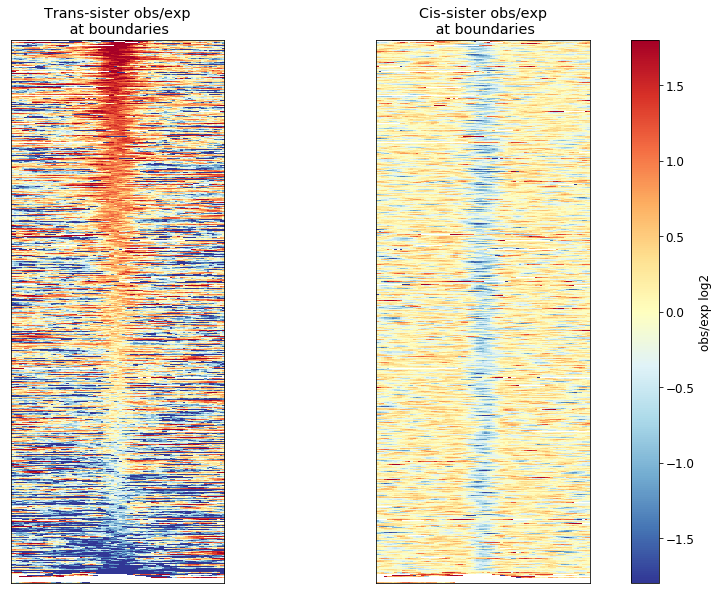

In [66]:
# add pseudocount
wtPrepared["trans"] = wtPrepared["trans"] + 0.01
wtPrepared["cis"] = wtPrepared["cis"] + 0.01


f, ax = plt.subplots(1, 2)
im = ax[0].imshow(np.log2(wtPrepared["trans"]), vmin=-1.8, vmax=1.8, aspect=0.05, cmap="RdYlBu_r", rasterized=True)
ax[1].imshow(np.log2(wtPrepared["cis"]), vmin=-1.8, vmax=1.8, aspect=0.05, cmap="RdYlBu_r", rasterized=True)
ax[0].set(title="Trans-sister obs/exp\n at boundaries")
ax[1].set(title="Cis-sister obs/exp\n at boundaries")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

## Write to file

In [68]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "Line_profile_heatmap_TAD_boundaries.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Line_profile_heatmap_TAD_boundaries.pdf"), bbox_inches="tight")

# Plot stack-up at TAD-boundaries for all TADs

## Define cooler file-handle

In [29]:
HICPATH = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"
BINSIZE = 20000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Prepare TADs

In [30]:
regionsAnnotated = cooltools.snipping.assign_regions(tadFrame,  list(arms.itertuples(index=False, name=None))).dropna()
regionsAnnotated.loc[:, "size"] = regionsAnnotated["end"] - regionsAnnotated["start"]
regionsAnnotated.loc[:, "mid"] = (regionsAnnotated["start"] + regionsAnnotated["end"])//2
windowsTADs = HT.assignRegions(3000000, 20000, regionsAnnotated["chrom"], regionsAnnotated["mid"], arms).dropna()

## Get individual regions

In [31]:
pileupIndICCF = {interType: HT.doPileupICCF(clrs[interType], windowsTADs, collapse=False)
                 for interType in ["cis", "trans"]}

## Compute sliding window along these regions

In [36]:
allTADs1dICCF = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCF[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=5)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    allTADs1dICCF[rType] = pd.concat(tempList)

0
1000
2000
3000
4000
5000
0
1000
2000
3000
4000
5000


## Get sizes of regions sort IDs based on it

In [37]:
regionsAnnotated.loc[:, "ID"] = range(len(regionsAnnotated))
sortedSize = regionsAnnotated.sort_values(by="size", ascending=True)["ID"]

In [38]:
allTADsResult = {}
for rType in ["cis", "trans"]:
    temp = allTADs1dICCF[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSize,:].dropna(how="all")
    allTADsResult[rType] = tempExp

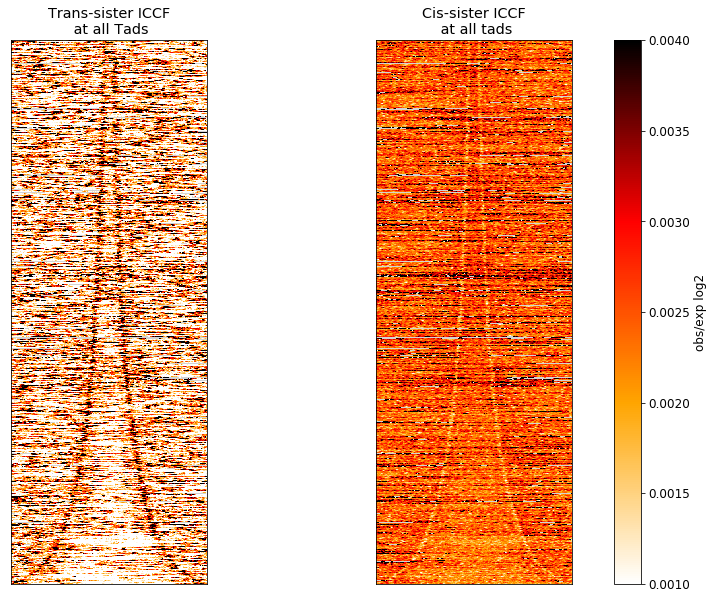

In [39]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")

f, ax = plt.subplots(1, 2)
im = ax[0].imshow(allTADsResult["trans"], vmin=0.001, vmax=0.004, cmap=cmap, aspect=0.15)
ax[1].imshow(allTADsResult["cis"], vmin=0.03, vmax=0.09, cmap=cmap, aspect=0.15)
ax[0].set(title="Trans-sister ICCF\n at all Tads")
ax[1].set(title="Cis-sister ICCF\n at all tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [40]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "Line_profile_heatmap_TAD_boundaries.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Line_profile_heatmap_TAD_boundaries.pdf"), bbox_inches="tight")

# Visualize TADs

In [37]:
tadSizes = np.zeros(allTADsResult["trans"].shape)
for index, value in enumerate(allTADsResult["trans"].columns):
    if np.isclose(value, 0):
        print(index)

148


In [38]:
# get only TADs that do not have all nans in
regionsSub = regionsAnnotated.loc[allTADsResult["trans"].index, :]
tadsSorted = regionsSub.sort_values(by="size")

testBins = []

for index, tad in enumerate(tadsSorted.iterrows()):
    size = tad[1]["size"]
    sizeHalf = size//2
    numberBins = sizeHalf//20000
    testBins.append(numberBins)
    tadBinsLeft = [148 - i for i in [numberBins + 1, numberBins, numberBins -1 ]]
    tadBinsRight = [148 + i for i in [numberBins + 1, numberBins, numberBins -1 ]]
    tadBins = tadBinsLeft + tadBinsRight
    try:
        tadSizes[index, tadBins] = 1
    except IndexError:
        continue

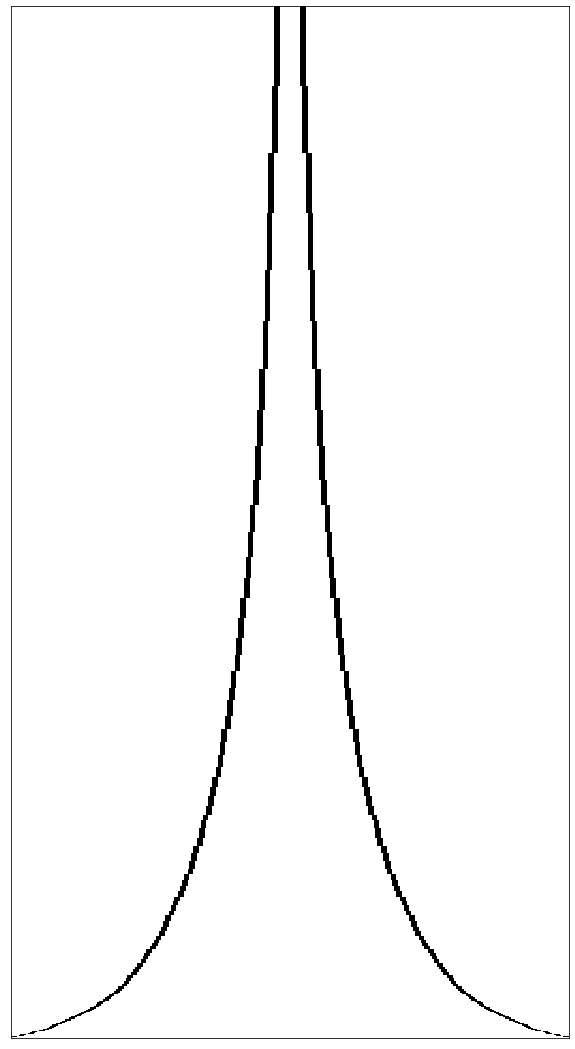

In [39]:
f, ax = plt.subplots()
ax.imshow(tadSizes, cmap="Greys", aspect=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
f.set_size_inches(10, 20)
plt.show()